# Blood Cells CNN 

## Important liberaries

In [1]:
# Import liberaries
import numpy as np
#import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt


## Loading Data

In [2]:
!pip install opendatasets
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Skipping, found downloaded files in "./blood-cells-image-dataset" (use force=True to force download)


In [3]:
data_path='/content/blood-cells-image-dataset/bloodcells_dataset'

## Data Spliting

In [4]:
# Creating the Train dataset and Validation dataset
train_ds= tf.keras.utils.image_dataset_from_directory(
  directory=data_path,
  validation_split=0.3,
  batch_size=11965,
  seed=222,
  subset="training",
  image_size=(100, 100),                                     
  ) 

Found 17092 files belonging to 8 classes.
Using 11965 files for training.


In [5]:
# Creating the Train dataset and Validation dataset
val_ds= tf.keras.utils.image_dataset_from_directory(
  directory=data_path,
  validation_split=0.3,
  batch_size=5127,
  seed=222,
  subset="validation",
  image_size=(100, 100),                                     
  ) 

Found 17092 files belonging to 8 classes.
Using 5127 files for validation.


In [6]:
# Get Class names 
class_names=train_ds.class_names
print(class_names)

['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


## Data Visualization

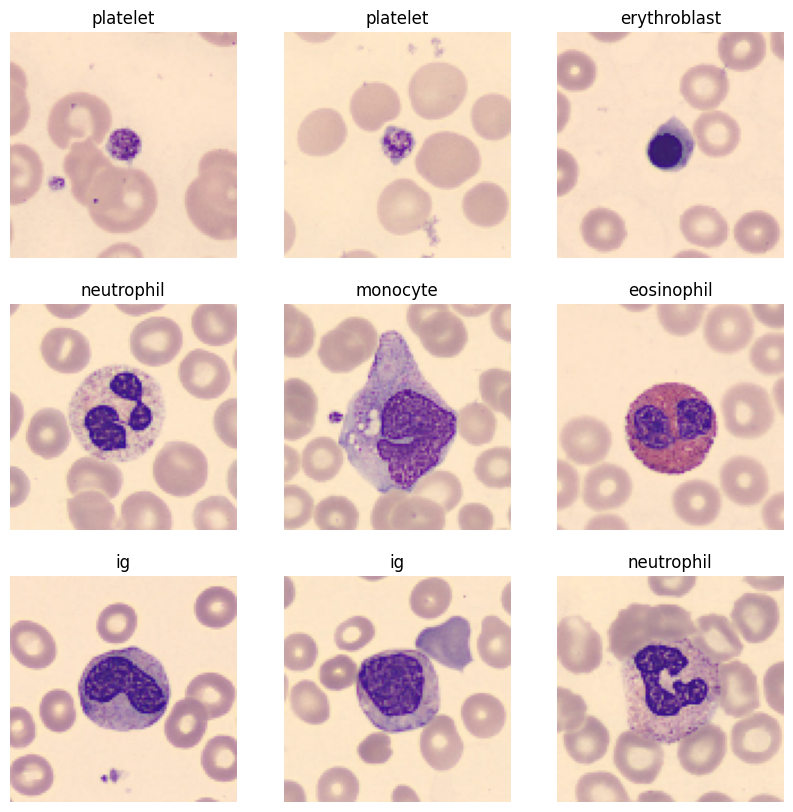

In [7]:
# Showing some figures from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Data Preprocessing

In [8]:
# Tap into the shape of a single batch of training data
for img_train, label_train in train_ds:
    print(img_train.shape)
    print(label_train.shape)
    break

(11965, 100, 100, 3)
(11965,)


In [9]:
# Tap into the shape of a single batch of validation data
for img_test, label_test in val_ds:
    print(img_test.shape)
    print(label_test.shape)
    break

(5127, 100, 100, 3)
(5127,)


In [10]:
# Pixel value of the image falls between 0 to 255.
# Normalize the data. Before we need to connvert data type to float for computation.
img_train = img_train.numpy().astype('float32')
img_test = img_test.numpy().astype('float32')
img_train /= 255
img_test /= 255
# So, we are scale the value between 0 to 1 before by deviding each value by 255
print(img_train.shape)
print(img_test.shape)


(11965, 100, 100, 3)
(5127, 100, 100, 3)


In [11]:
# Convert class vectors to binary class matrices. This is called one hot encoding.
print (" Shape before one-hot encoding : ", label_train.shape)
label_train = keras.utils.to_categorical(label_train, len(class_names))

label_test = keras.utils.to_categorical(label_test, len(class_names))
print (" Shape after one-hot encoding : ", label_test.shape)

 Shape before one-hot encoding :  (11965,)
 Shape after one-hot encoding :  (5127, 8)


## CNN Model Building
-In the first stage, Our net will learn 32 convolutional filters, each of which with a 3 x 3 size. The output dimension is the same one of the input shape, so it will be 32 x 32 and activation is relu, which is a simple way of introducing non-linearity; folowed by another 32 convolutional filters, each of which with a 3 x 3 size and activation is also relu. After that we have a max-pooling operation with pool size 2 x 2 and a dropout at 25%.

-In the next stage in the deep pipeline, Our net will learn 64 convolutional filters, each of which with a 3 x 3 size. The output dimension is the same one of the input shape and activation is relu; folowed by another 64 convolutional filters, each of which with a 3 x 3 size and activation is also relu. After that we have a max-pooling operation with pool size 2 x 2 and a dropout at 25%.

-And the Final stage in the deep pipeline is a dense network with 512 units and relu activation followed by a dropout at 50% and by a softmax layer with 10 classes as output, one for each category.

In [12]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# a softmax classifier
model.add(Dense(8))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 98, 98, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                        

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Fitting The Model on train and validation dataset
#model.fit(img_train,label_train, validation_data=(img_test,label_test),epochs=73)

In [15]:
model.fit(img_train,label_train, validation_data=(img_test,label_test),epochs=15)

Epoch 1/15
374/374 [==============================] - 34s 45ms/step - loss: 1.2452 - accuracy: 0.5238 - val_loss: 0.5227 - val_accuracy: 0.7862
Epoch 2/15
374/374 [==============================] - 13s 34ms/step - loss: 0.5882 - accuracy: 0.7866 - val_loss: 0.4038 - val_accuracy: 0.8444
Epoch 3/15
374/374 [==============================] - 13s 35ms/step - loss: 0.4288 - accuracy: 0.8486 - val_loss: 0.3456 - val_accuracy: 0.8822
Epoch 4/15
374/374 [==============================] - 13s 34ms/step - loss: 0.3573 - accuracy: 0.8781 - val_loss: 0.3404 - val_accuracy: 0.8894
Epoch 5/15
374/374 [==============================] - 13s 35ms/step - loss: 0.2932 - accuracy: 0.9029 - val_loss: 0.4192 - val_accuracy: 0.8695
Epoch 6/15
374/374 [==============================] - 13s 34ms/step - loss: 0.2274 - accuracy: 0.9270 - val_loss: 0.2652 - val_accuracy: 0.9066
Epoch 7/15
374/374 [==============================] - 13s 34ms/step - loss: 0.1731 - accuracy: 0.9440 - val_loss: 0.3023 - val_accuracy:

In [16]:
model.save('/content/blood-cells-image-dataset')

## Model Loss and Accuracy

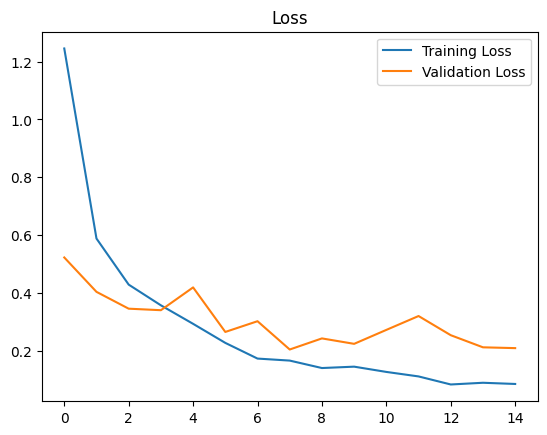

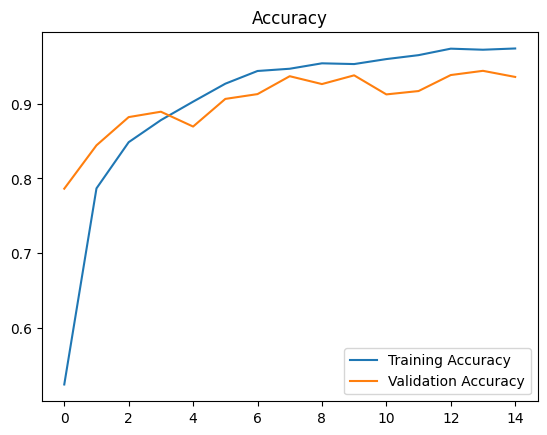

In [17]:
# Plot Model Loss and Model accuracy
history = model.history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

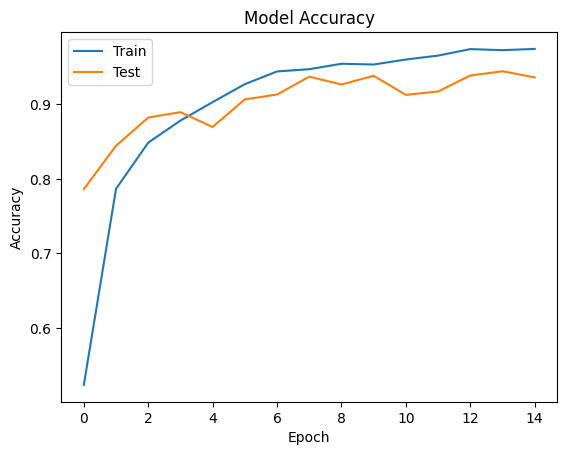

In [18]:
# Plot the accuracy graph
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluating

In [19]:
# Grab a batch of data
for images, labels in val_ds.take(1):
    eval_images = images.numpy()
    eval_labels = labels.numpy()

161/161 [==============================] - 1s 6ms/step


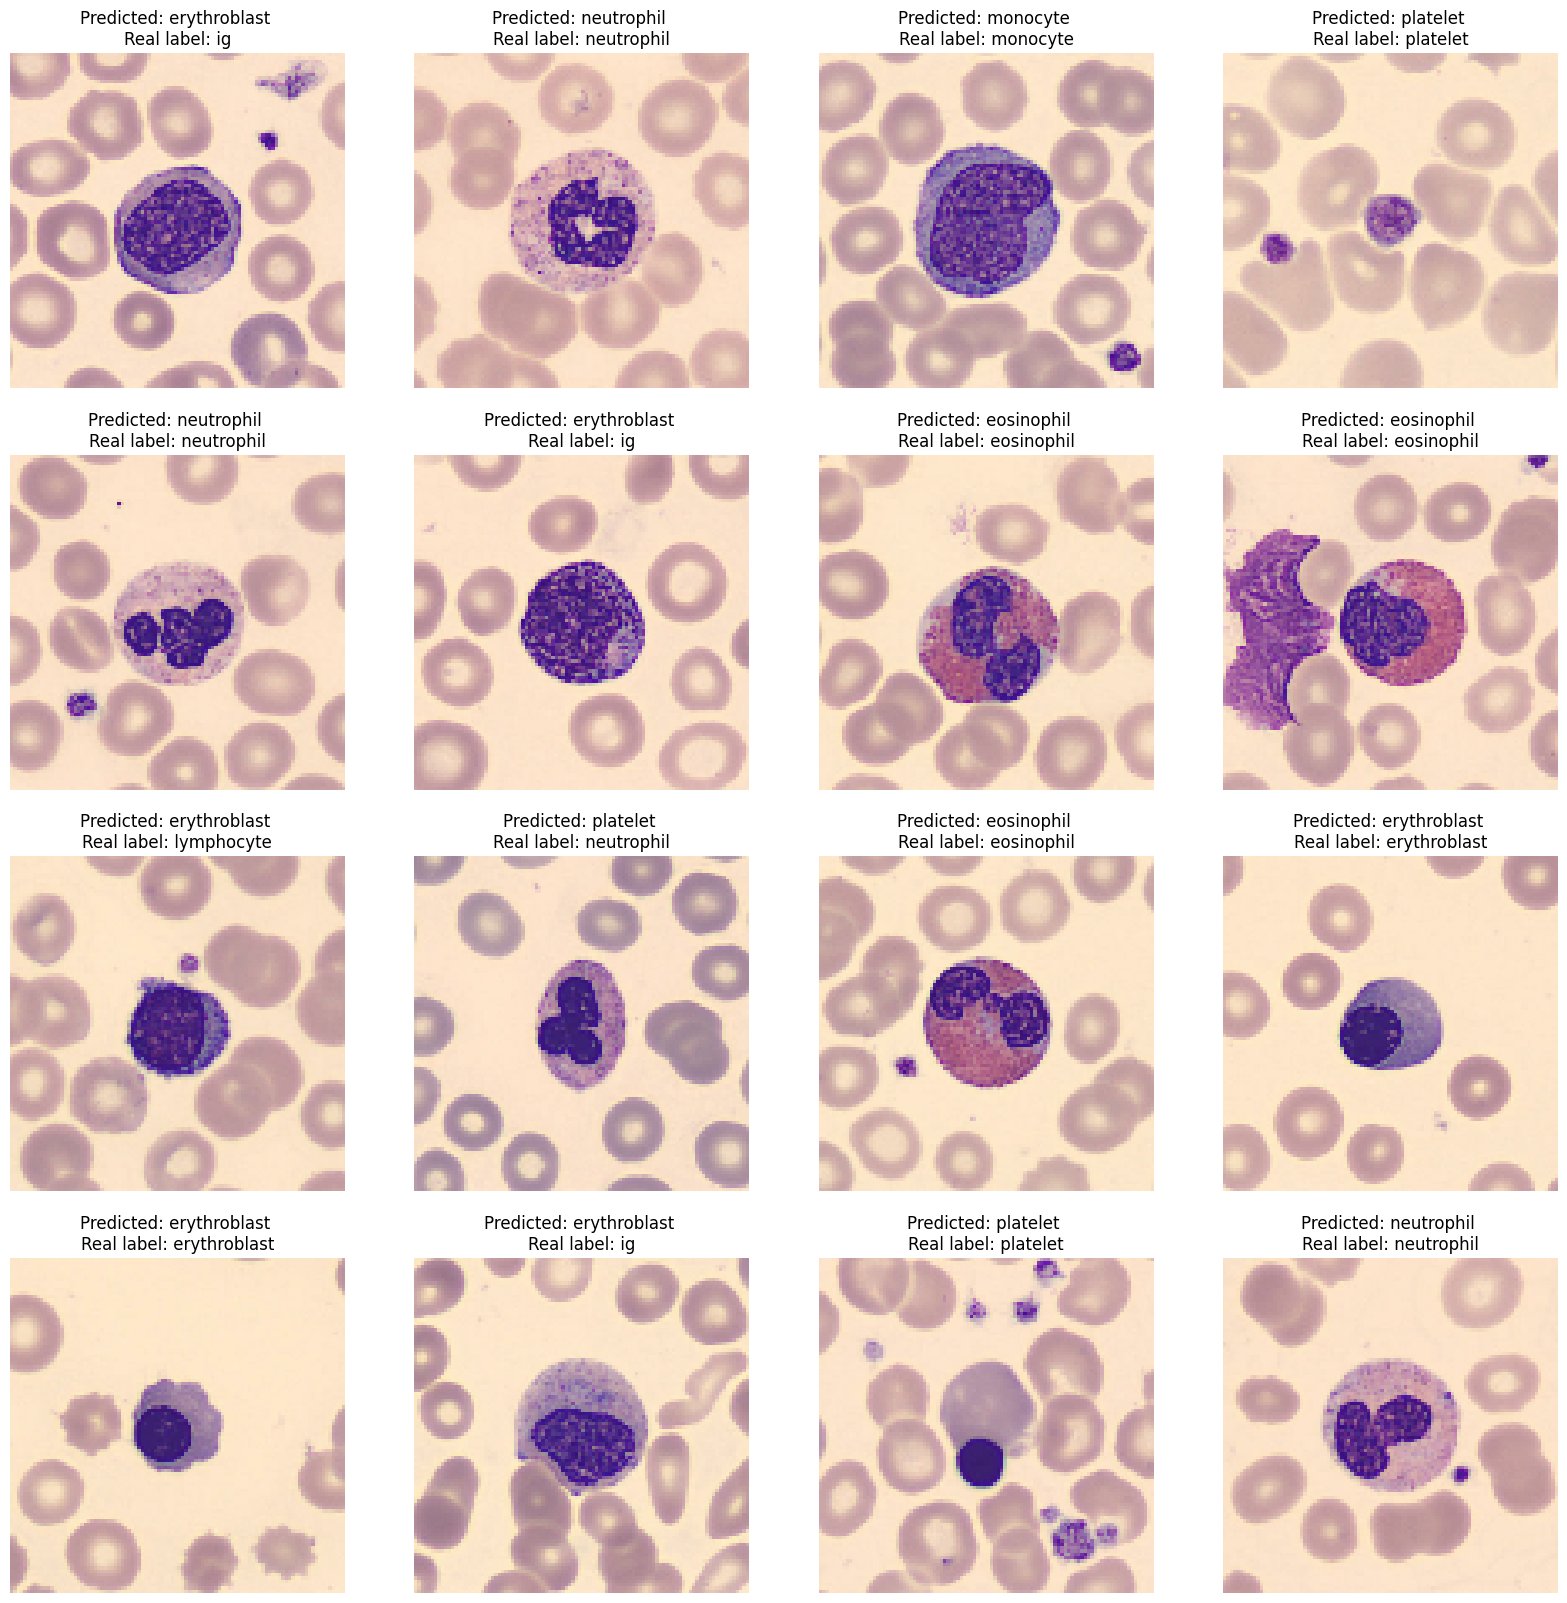

In [20]:
plt.figure(figsize=(20, 20))

# Generate predictions
predictions = model.predict(eval_images)
predicted_indexes = np.argmax(predictions, axis=1)
        

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)

    # Show image
    plt.imshow(eval_images[i].astype("uint8"))

    # Predicted class
    predicted_class = class_names[predicted_indexes[i]]

    # Real class
    real_class = class_names[eval_labels[i]]

    # Title 
    plt.title(f'Predicted: {predicted_class} \nReal label: {real_class}')

    plt.axis("off")


161/161 [==============================] - 1s 6ms/step


([], [])

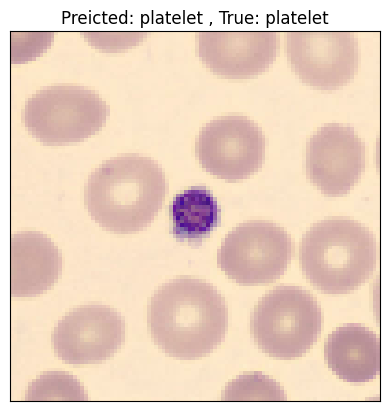

In [21]:
# Generate predictions
predicted_classes = np.argmax(model.predict(img_test), axis=1)
predicted_classes

# Testing an image from the dataset
plt.imshow(img_test[55].reshape(100,100,3))
plt.title("Preicted: {} , True: {}".format(class_names[predicted_classes[55]],class_names[np.argmax(label_test[55])]))
plt.xticks([])
plt.yticks([])

## Confusion Matrix

Exception ignored in: <function UniquePtr.__del__ at 0x7fe7221f52d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/c_api_util.py", line 74, in __del__
    self.deleter(obj)
KeyboardInterrupt: 


161/161 [==============================] - 1s 6ms/step


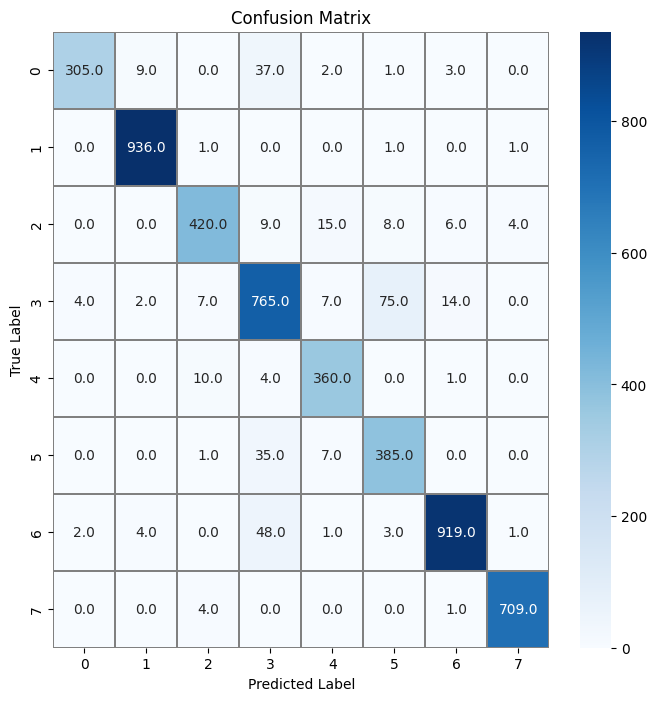

In [22]:
from sklearn.metrics import confusion_matrix
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(img_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax( label_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Classification Report

In [23]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(np.argmax(label_test, axis=1), predicted_classes, target_names=class_names)

# Print classification report
print(report)

              precision    recall  f1-score   support

    basophil       0.98      0.85      0.91       357
  eosinophil       0.98      1.00      0.99       939
erythroblast       0.95      0.91      0.93       462
          ig       0.85      0.88      0.86       874
  lymphocyte       0.92      0.96      0.94       375
    monocyte       0.81      0.90      0.85       428
  neutrophil       0.97      0.94      0.96       978
    platelet       0.99      0.99      0.99       714

    accuracy                           0.94      5127
   macro avg       0.93      0.93      0.93      5127
weighted avg       0.94      0.94      0.94      5127



## AUC Graph

161/161 [==============================] - 1s 6ms/step


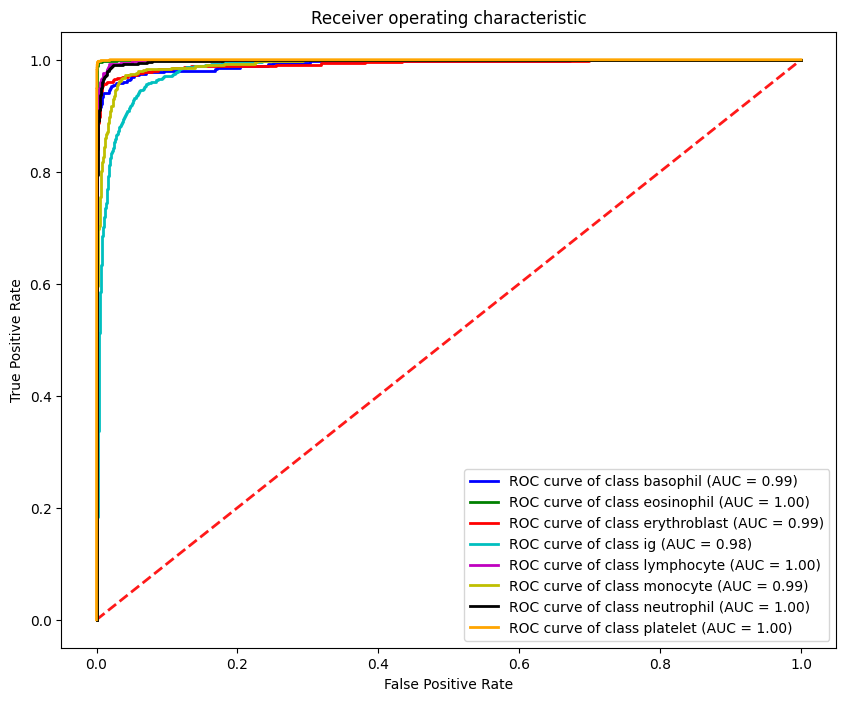

In [24]:
from sklearn.metrics import roc_curve, auc

# Generate predictions
y_score = model.predict(img_test)

# Convert one-hot encoded labels to integer labels
y_true = np.argmax(label_test, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.9)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class %s (AUC = %0.2f)' % (class_names[i], roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()